We propose a semi-supervised learning method for tabular data that does not require any domain-specific assumption. The method we propose is based on pseudo-labeling of a set of unlabeled data using Confident Sinkhorn Allocation (CSA). Our method is theoretically driven by the role of uncertainty in robust label assignment in SSL. CSA will assign labels to only the data samples with high confidence scores using Sinkhorn’s algorithm. By learning the label assignment with optimal transport, CSA eliminates the need to predefine the heuristic thresholds used in existing pseudo-labeling methods, which can be greedy. The proposed CSA is applicable to any data domain, and could be used in concert with consistency-based approaches, but is particularly useful for tabular data where pretext tasks and data augmentation are not applicable.

In [1]:
!git clone https://github.com/amzn/confident-sinkhorn-allocation.git

Cloning into 'confident-sinkhorn-allocation'...
remote: Enumerating objects: 2201, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 2201 (delta 40), reused 22 (delta 10), pack-reused 2125
Receiving objects: 100% (2201/2201), 52.93 MiB | 12.62 MiB/s, done.
Resolving deltas: 100% (864/864), done.


In [1]:
%cd confident-sinkhorn-allocation

/content/confident-sinkhorn-allocation


In [18]:
!pip install numpy==1.23.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 32.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.2
    Uninstalling numpy-1.25.2:
      Successfully uninstalled numpy-1.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.0 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy>=1.25.0; python_version >= "3.9", but you have numpy 1.23.0 which is incompatible.
tensorflow 2.15.0 requires numpy<2.0.0,>=1.23.5, but you have numpy 1.23.0 which is incompatible.


In [2]:
import sys
sys.path.append('..')

import numpy as np
import os
import argparse
import logging
import pickle
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def str2num(s, encoder):
    return encoder[s]

def append_acc_early_termination(AccList, NumIter):

    if len(AccList)<=NumIter:
        Acc_Last_Iter=AccList[-1]
        AccList = AccList + [Acc_Last_Iter]*(1+NumIter-len(AccList))

    return AccList

def rename_dataset(dataset_name):
    print(dataset_name)
    newname=[]

    if dataset_name=="madelon_no":
        return "Madelon"
    elif dataset_name=="synthetic_control_6c":
        return "Synthetic Control"
    elif dataset_name=="digits":
        return "Digits"
    elif dataset_name=="analcatdata_authorship":
        return "Analcatdata"
    elif dataset_name=="German-credit":
        return "German Credit"
    elif dataset_name=="segment_2310_20":
        return "Segment"
    elif dataset_name=="wdbc_569_31":
        return "Wdbc"
    elif dataset_name=="dna_no":
        return "Dna"
    elif dataset_name=="agaricus-lepiota":
        return "Agaricus-Lepiota"
    elif dataset_name=="breast_cancer":
        return "Breast Cancer"
    elif dataset_name=="agaricus-lepiota":
        return "Agaricus-Lepiota"
    elif dataset_name=="emotions":
        return "Emotions"


# 18,7,6,4,2
def get_train_test_unlabeled(_datasetName,path_to_data,random_state=0): # for multi-classification
    """
    path_to_data='all_data.pickle'
    """

    # load the data
    with open(path_to_data, 'rb') as handle:
        [all_data, datasetName_list] = pickle.load(handle)

    dataset_index= datasetName_list.index(_datasetName)
    data=all_data[dataset_index]

    #if dataset_index<14:
    if _datasetName in ['segment_2310_20','wdbc_569_31','steel-plates-fault','analcatdata_authorship','synthetic_control_6c',\
    'vehicle_846_19','German-credit','gina_agnostic_no','madelon_no','texture','gas_drift','dna_no']:
        _dic = list(set(data.values[:, -1]))
        num_labels = len(_dic)
        encoder = {}
        for i in range(len(_dic)):
            encoder[_dic[i]] = i

        # shuffle original dataset
        data = data.sample(frac=1,random_state=42)
        X = data.values[:, :-1]
        # X = scale(X)  # scale the X
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
        Y = np.array([str2num(s, encoder) for s in data.values[:, -1]])
    else:
        X = data[:, :-1]
        Y=data[:,-1]


    #if dataset_index in [9,1,16]:
    if _datasetName in ['hill-valley','gina_agnostic_no','agaricus-lepiota']:
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                            random_state=random_state)

        x_train, x_unlabeled, y_train, y_unlabeled = train_test_split(x_train, y_train,
                                                      test_size=0.6, random_state=random_state)

    #elif dataset_index in [17,8]:
    elif _datasetName in ['German-credit','breast_cancer']:
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                            random_state=random_state)

        x_train, x_unlabeled, y_train, y_unlabeled = train_test_split(x_train, y_train,
                                                      test_size=0.8, random_state=random_state)


    #elif dataset_index in [18,6,4]:
    elif _datasetName in ['steel-plates-fault','synthetic_control_6c','digits']:

        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                            random_state=random_state)

        x_train, x_unlabeled, y_train, y_unlabeled = train_test_split(x_train, y_train,
                                                      test_size=0.9, random_state=random_state)



    #elif dataset_index in [10,15,12,14,11,13]: # label / unlabel > 15:1
    elif _datasetName in ['madelon_no','texture','gas_drift','dna_no','car','kr_vs_kp']:
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                            random_state=random_state)

        x_train, x_unlabeled, y_train, y_unlabeled = train_test_split(x_train, y_train,
                                                      test_size=0.94, random_state=random_state)

    #elif dataset_index in [3,5]: # label / unlabel > 15:1
    elif _datasetName in ['wdbc_569_31','analcatdata_authorship']:

        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                            random_state=random_state)

        x_train, x_unlabeled, y_train, y_unlabeled = train_test_split(x_train, y_train,
                                                      test_size=0.9, random_state=random_state)

    #elif dataset_index in [7]:
    elif _datasetName in ['vehicle_846_19']:

        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                            random_state=random_state)

        x_train, x_unlabeled, y_train, y_unlabeled = train_test_split(x_train, y_train,
                                                      test_size=0.8, random_state=random_state)

    #elif dataset_index in [2]:
    elif _datasetName in ['segment_2310_20']:
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2,
                                                            random_state=random_state)

        x_train, x_unlabeled, y_train, y_unlabeled = train_test_split(x_train, y_train,
                                                      test_size=0.7, random_state=random_state)
    else:
        print(_datasetName + "is not defined. please check!")


    p = np.random.permutation(x_train.shape[0])
    x_train, y_train = x_train[p], y_train[p]

    p = np.random.permutation(x_unlabeled.shape[0])
    x_unlabeled, y_unlabeled = x_unlabeled[p], y_unlabeled[p]

    y_test=np.reshape(y_test,(-1,1))
    y_train=np.reshape(y_train,(-1,1))


    return x_train,y_train, x_test, y_test, x_unlabeled


def get_train_test_unlabeled_for_multilabel(_datasetName,path_to_data='all_data_multilabel.pickle',random_state=0): # for multi-label classification
    """
    path_to_data='all_data.pickle'
    """

    # load the data
    with open(path_to_data, 'rb') as handle:
        [all_data, datasetName_list] = pickle.load(handle)

    dataset_index= datasetName_list.index(_datasetName)
    data=all_data[dataset_index]

    X = data['data']
    Y=data['target']


    if _datasetName=="emotions": # emotions dataset
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=random_state)

        x_train, x_unlabeled, y_train, y_unlabeled = train_test_split(x_train, y_train,
                                                        test_size=0.5, random_state=random_state)
    elif _datasetName=="genbase": # genbase dataset
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=random_state)

        x_train, x_unlabeled, y_train, y_unlabeled = train_test_split(x_train, y_train,
                                                        test_size=0.7, random_state=random_state)
    elif _datasetName=="yeast": # yeast dataset
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=random_state)

        x_train, x_unlabeled, y_train, y_unlabeled = train_test_split(x_train, y_train,
                                                        test_size=0.7, random_state=random_state)
    else:
        print(_datasetName + "is not defined. please check!")


    p = np.random.permutation(x_train.shape[0])
    x_train, y_train = x_train[p], y_train[p]

    p = np.random.permutation(x_unlabeled.shape[0])
    x_unlabeled, y_unlabeled = x_unlabeled[p], y_unlabeled[p]

    return x_train,y_train, x_test, y_test, x_unlabeled

In [4]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier
import copy
import sklearn

class Pseudo_Labeling(object):
    # implementation of the master class for pseudo-labeling
    # this class will be inherited across other subclasses

    def __init__(self, unlabelled_data, x_test,y_test, num_iters=5,upper_threshold = 0.8, \
            fraction_allocation=1,lower_threshold = None,num_XGB_models=0, \
                 verbose = False,IsMultiLabel=False):
        """
        unlabelled_data      : [N x d] where N is the number of unlabeled data, d is the feature dimension
        x_test               :[N_test x d]
        y_test               :[N_test x 1] for multiclassification or [N_test x K] for multilabel classification
        num_iters            : number of pseudo-iterations, recommended = 5 as in the paper
        upper_threshold      : the upper threshold used for pseudo-labeling, e.g., we assign label if the prob > 0.8
        fraction_allocation  : the faction of label allocation, if fraction_allocation=1, we assign labels to 100% of unlabeled data
        lower_threshold      : lower threshold, used for UPS
        num_XGB_models       : number of XGB models used for UPS and CSA, recommended = 10
        verbose              : verbose
        IsMultiLabel         : False => Multiclassification or True => Multilabel classification
        """

        self.IsMultiLabel=False
        self.algorithm_name="Pseudo_Labeling"
        self.x_test=x_test
        self.y_test=y_test

        self.IsMultiLabel=IsMultiLabel

        # for house keeping and reporting purpose
        self.len_unlabels=[]
        self.len_accepted_ttest=[]
        self.len_selected=[]
        self.num_augmented_per_class=[]


        # this is the XGBoost model for multi-class classification
        param = {}
        param['booster'] = 'gbtree'
        param['objective'] = 'binary:logistic'
        param['verbosity'] = 0
        param['silent'] = 1
        param['seed'] = 0

        # create XGBoost instance with default hyper-parameters
        #xgb = XGBClassifier(**param,use_label_encoder=False)
        xgb = self.get_XGB_model(param)

        self.model = copy.copy(xgb)

        self.unlabelled_data = unlabelled_data # this is a temporary unlabelled data changing in each iteration
        self.verbose = verbose
        self.upper_threshold = upper_threshold
        self.num_iters=num_iters

        if lower_threshold is not None:
            self.lower_threshold = lower_threshold # this lower threshold is used for UPS algorithm, not the vanilla Pseudo-labeling


        # allow the pseudo-data is repeated, e.g., without removing them after each iteration
        # create a list of all the indices
        self.unlabelled_indices = list(range(unlabelled_data.shape[0]))

        self.selected_unlabelled_index=[]

        if self.verbose:
            print("no of unlabelled data:",unlabelled_data.shape[0], "\t no of test data:",x_test.shape[0])

        # Shuffle the indices
        np.random.shuffle(self.unlabelled_indices)
        self.test_acc=[]
        self.FractionAllocatedLabel=fraction_allocation # we will allocate labels to 100% of the unlabeled dataset
        self.num_XGB_models=num_XGB_models # this is the parameter M in our paper

        if num_XGB_models>1: # will be used for CSA and UPS
            # for uncertainty estimation
            # generate multiple models
            params = { 'max_depth': np.arange(3, 20).astype(int),
                    'learning_rate': [0.01, 0.1, 0.2, 0.3],
                    'subsample': np.arange(0.5, 1.0, 0.05),
                    'colsample_bytree': np.arange(0.4, 1.0, 0.05),
                    'colsample_bylevel': np.arange(0.4, 1.0, 0.05),
                    'n_estimators': [100, 200, 300, 500, 600, 700, 1000]}

            self.XGBmodels_list=[0]*self.num_XGB_models

            param_list=[0]*self.num_XGB_models
            for tt in range(self.num_XGB_models):

                param_list[tt]={}

                for key in params.keys():

                    mychoice=np.random.choice(params[key])

                    param_list[tt][key]=mychoice
                    param_list[tt]['verbosity'] = 0
                    param_list[tt]['silent'] = 1
                    param_list[tt]['seed'] = tt

                #self.XGBmodels_list[tt] = XGBClassifier(**param_list[tt],use_label_encoder=False)
                self.XGBmodels_list[tt] = self.get_XGB_model(param_list[tt])


    def get_XGB_model(self,param):
        """
        we create the XGB model depending on multiclass or multi-label setting
        Args:
            param: a predefined hyperparameter for XGBmodel

        Output:
            a single XGBClassifier for multiclass
            or
            a single MultiOutputClassifier for multilabel
        """

        if self.IsMultiLabel==False:
            return XGBClassifier(**param,use_label_encoder=False)
        else:
            return MultiOutputClassifier(XGBClassifier(**param,use_label_encoder=False))

    def get_predictive_prob_for_unlabelled_data(self, model):
        """
        Compute the predictive probability within [0,1] for unlabelled data given a single XGB model
        Args:
            model: a single XGBmodel

        Output:
            predictive probability matrix [N x K]
        """

        pseudo_labels_prob = model.predict_proba(self.unlabelled_data)

        # number of unlabeled data
        if self.IsMultiLabel==True:
            pseudo_labels_prob=np.asarray(pseudo_labels_prob).T
            pseudo_labels_prob=pseudo_labels_prob[1,:,:]

        return pseudo_labels_prob

    def estimate_label_frequency(self, y):
        """
        estimate the label frequency empirically from the initial labeled data
        Args:
            y: label vector or matrix (multilabel)

        Output:
            Given K the number of labels, it returns a vector of label frequency [1 x K]
        """


        if self.IsMultiLabel==False:
            if len(self.num_augmented_per_class)>0:
                unique, label_frequency = np.unique( y[np.sum(self.num_augmented_per_class):], return_counts=True)
            else:
                unique, label_frequency = np.unique( y, return_counts=True)
        else:
            label_frequency = np.sum( y, axis=0)

        if self.verbose:
            print("==label_frequency without adjustment", np.round(label_frequency,3))

        # smooth the label frequency if the ratio between the max class / min class is significant >5
        # this smoothing is the implementation trick to prevent biased estimation given limited training data
        ratio=np.max(label_frequency)/np.min(label_frequency)
        if ratio>5:
            label_frequency=label_frequency/np.sum(label_frequency)+np.ones( self.nClass )*1.0/self.nClass

        return label_frequency/np.sum(label_frequency)



    def evaluate_performance(self):
        """
        evaluate_performance the classification performance
        Store the result into: self.test_acc which is the accuracy for multiclassification \
                                                    or the precision for multilabel classification
        """


        y_test_pred = self.model.predict(self.x_test)

        if self.IsMultiLabel==False:
            test_acc= np.round( accuracy_score(y_test_pred, self.y_test)*100, 2)# round to 2 digits xx.yy %

            if self.verbose:
                print('+++Test Acc: {:.2f}%'.format(test_acc))
            self.test_acc +=[test_acc]
        else: # multi-label classification

            # Precision
            prec=sklearn.metrics.precision_score(self.y_test, y_test_pred,average='samples')*100
            prec=np.round(prec,2) # round to 2 digits xx.yy %

            self.test_acc +=[prec] # precision score

            if self.verbose:
                print('+++Test Acc: {:.2f}%'.format(prec))


    def get_prob_at_max_class(self,pseudo_labels_prob):
        """
        Given the 2d probability matrix [N x K], we get the probability at the maximum index
        Args:
           pseudo_labels_prob: 2d probability matrix [N x K]

        Returns:
           max_prob_matrix: probability at argmax class [N x 1]
        """
        max_prob_matrix=np.zeros((pseudo_labels_prob.shape))
        for ii in range(pseudo_labels_prob.shape[0]):  # loop over each data point
            idxMax=np.argmax(pseudo_labels_prob[ii,:]) # find the highest score class
            max_prob_matrix[ii,idxMax]=pseudo_labels_prob[ii,idxMax]
        return max_prob_matrix

    def post_processing_and_augmentation(self,assigned_pseudo_labels,X,y):
        """
        after assigning the pseudo labels in the previous step, we post-process and augment them into X and y
        Args:
            assigned_pseudo_labels: [N x K] matrix where N is the #unlabels and K is the #class
            assigned_pseudo_labels==0 indicates no assignment
            assigned_pseudo_labels==1 indicates assignment.

            X: existing pseudo_labeled + labeled data [ N' x d ]
            y: existing pseudo_labeled + labeled data [ N' x 1 ] for multiclassification
            y: existing pseudo_labeled + labeled data [ N' x K ] for multilabel classification
        Output:
            Augmented X
            Augmented y
        """

        sum_by_cols=np.sum(assigned_pseudo_labels,axis=1)
        labels_satisfied_threshold = np.where(sum_by_cols>0)[0]

        self.num_augmented_per_class.append( np.sum(assigned_pseudo_labels,axis=0).astype(int) )

        if len(labels_satisfied_threshold) == 0: # no point is selected
            return X,y

        self.selected_unlabelled_index += labels_satisfied_threshold.tolist()

        # augment the assigned labels to X and y ==============================================
        X = np.vstack((self.unlabelled_data[labels_satisfied_threshold,:], X))

        if self.IsMultiLabel==False: # y is [N x 1] matrix
            # allow a single data point can be added into multiple
            y = np.vstack(( np.argmax( assigned_pseudo_labels[labels_satisfied_threshold,:],axis=1).reshape(-1,1), np.array(y).reshape(-1,1)))

        else: # y is [N x L] matrix
            y = np.vstack((assigned_pseudo_labels[labels_satisfied_threshold,:], np.array(y)))


        if "CSA" in self.algorithm_name: # book keeping
            self.len_unlabels.append( len(self.unlabelled_data) )
            self.len_accepted_ttest.append( assigned_pseudo_labels.shape[0] )
            self.len_selected.append(  np.sum(self.num_augmented_per_class) )


        # remove the selected data from unlabelled data
        self.unlabelled_data = np.delete(self.unlabelled_data, np.unique(labels_satisfied_threshold), 0)

        return X,y

    def label_assignment_and_post_processing(self, pseudo_labels_prob,X,y, current_iter=0,upper_threshold=None):
        """
        Given the threshold, we perform label assignment and post-processing

        Args:
            pseudo_labels_prob: predictive prob [N x K] where N is #unlabels, K is #class
            X: existing pseudo_labeled + labeled data [ N' x d ]
            y: existing pseudo_labeled + labeled data [ N' x 1 ] for multiclassification
            y: existing pseudo_labeled + labeled data [ N' x K ] for multilabel classification

        Output:
            Augmented X = augmented_X + X
            Augmented y = augmented_y + Y
        """

        if self.IsMultiLabel==False:
            #go over each row (data point), only keep the argmax prob
            # because we only allow a single data point to a single class
            max_prob_matrix=self.get_prob_at_max_class(pseudo_labels_prob)
        else:
            # we dont need to get prob at max class for multi-label
            # because a single data point can be assigned to multiple classes
            max_prob_matrix=pseudo_labels_prob


        if upper_threshold is None:
            upper_threshold=self.upper_threshold

        if 'CSA' in self.algorithm_name: # if using CSA, we dont use the upper threshold
            upper_threshold=0

        assigned_pseudo_labels=np.zeros((max_prob_matrix.shape[0],self.nClass)).astype(int)

        MaxPseudoPoint=[0]*self.nClass
        for cc in range(self.nClass): # loop over each class

            MaxPseudoPoint[cc]=self.get_max_pseudo_point(self.label_frequency[cc],current_iter)

            idx_sorted = np.argsort( max_prob_matrix[:,cc])[::-1] # decreasing

            temp_idx = np.where(max_prob_matrix[idx_sorted,cc] > upper_threshold )[0]
            labels_satisfied_threshold=idx_sorted[temp_idx]

            # only select upto MaxPseudoPoint[cc] points
            labels_satisfied_threshold = labels_satisfied_threshold[:MaxPseudoPoint[cc]]
            assigned_pseudo_labels[labels_satisfied_threshold, cc]=1

        if self.verbose:
            print("MaxPseudoPoint",MaxPseudoPoint)

        return self.post_processing_and_augmentation(assigned_pseudo_labels,X,y)



    def get_number_of_labels(self,y):
        """
        # given the label y, return the number of classes

        Args:
            y: label vector (for singlelabel) or matrix (for multilabel)

        Output:
            number of classes or number of labels
        """


        if self.IsMultiLabel==False:
            return len(np.unique(y))
        else:
            return y.shape[1]



    def get_max_pseudo_point(self,fraction_of_class, current_iter):
        """
        We select more points at the begining and less at later stage

        Args:
            fraction_of_class: vector of the frequency of points per class
            current_iter: current iteration  0,1,2...T
        Output:
            number_of_max_pseudo_points: scalar
        """

        LinearRamp= [(self.num_iters-ii)/self.num_iters for ii in range(self.num_iters)]
        SumLinearRamp=np.sum(LinearRamp)

        fraction_iter= (self.num_iters-current_iter) / (self.num_iters*SumLinearRamp)
        MaxPseudoPoint=fraction_iter*fraction_of_class*self.FractionAllocatedLabel*len(self.unlabelled_data)

        return np.int(np.ceil(MaxPseudoPoint))


    def fit(self, X, y):
        """
        main algorithm to perform pseudo labelling

        Args:
            X: train features [N x d]
            y: train targets [N x 1]

        Output:
            we record the test_accuracy a vector of test accuracy per pseudo-iteration
        """
        print("=====",self.algorithm_name)

        self.nClass=self.get_number_of_labels(y)


        self.label_frequency=self.estimate_label_frequency(y)

        for current_iter in (tqdm(range(self.num_iters)) if self.verbose else range(self.num_iters)):
            self.selected_unlabelled_index=[]

            # Fit to data
            self.model.fit(X, y)

            # evaluate_performance the performance on test set after Fit the model given the data
            self.evaluate_performance()

            # Predictive probability on the unlabeled data
            pseudo_labels_prob=self.get_predictive_prob_for_unlabelled_data(self.model)

            X,y=self.label_assignment_and_post_processing(pseudo_labels_prob,X,y,current_iter)

            if self.verbose:
                print("#augmented:", self.num_augmented_per_class, " no training data ", len(y))

            if np.sum(self.num_augmented_per_class)==0: # no data point is augmented
                return

        # evaluate_performance at the last iteration for reporting purpose
        self.model.fit(X, y)

        self.evaluate_performance()

    # def predict(self, X):
    #     return self.model.predict(X)

    # def predict_proba(self, X):
    #     return self.model.predict_proba(X)

    # def decision_function(self, X):
    #     return self.model.decision_function(X)

In [5]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from scipy import stats
import time

# Confident Sinkhorn Allocation==================================================================================================
class CSA(Pseudo_Labeling):

    def __init__(self, unlabelled_data, x_test,y_test,num_iters=5,num_XGB_models=20,confidence_choice="ttest",verbose = False,IsMultiLabel=False):
        """
        unlabelled_data      : [N x d] where N is the number of unlabeled data, d is the feature dimension
        x_test               :[N_test x d]
        y_test               :[N_test x 1] for multiclassification or [N_test x K] for multilabel classification
        num_iters            : number of pseudo-iterations, recommended = 5 as in the paper
        upper_threshold      : the upper threshold used for pseudo-labeling, e.g., we assign label if the prob > 0.8
        fraction_allocation  : the faction of label allocation, if fraction_allocation=1, we assign labels to 100% of unlabeled data
        lower_threshold      : lower threshold, used for UPS
        num_XGB_models       : number of XGB models used for UPS and CSA, recommended = 10
        verbose              : verbose
        IsMultiLabel         : False => Multiclassification or True => Multilabel classification
        """

        super().__init__( unlabelled_data, x_test,y_test,num_iters=num_iters,num_XGB_models=num_XGB_models,verbose=verbose,IsMultiLabel=IsMultiLabel)


        self.confidence_choice=confidence_choice

        if self.IsMultiLabel==True:
            # by default, we use total_variance as the main criteria for multilabel classification
            if self.confidence_choice is not None:
                self.confidence_choice="variance"

        if self.confidence_choice is None or self.confidence_choice=="None":
            self.algorithm_name="SLA"
        else:
            self.algorithm_name="CSA_" + self.confidence_choice



        self.elapse_xgb=[]
        self.elapse_ttest=[]
        self.elapse_sinkhorn=[]

        if self.verbose:
            print("number of used XGB models  M=",self.num_XGB_models)

    def predict(self, X):
        super().predict(X)
    def predict_proba(self, X):
        super().predict_proba(X)
    def evaluate_performance(self):
        super().evaluate_performance()
    def get_max_pseudo_point(self,class_freq,current_iter):
        return super().get_max_pseudo_point(class_freq,current_iter)

    def set_ot_regularizer(self,nRow,nCol):
        """
        We set the Sinkhorn regularization parameter based on the ratio of Row/Column

        Args:
            nRow: number of rows in our cost matrix for Sinkhorn algorithm
            nCol: number of columns

        Output:
            regularization
        """

        if nRow/nCol>=300:
            regulariser=1
        if nRow/nCol>=200:
            regulariser=0.5
        elif nRow/nCol>=100:
            regulariser=0.2
        elif nRow/nCol>=50:
            regulariser=0.1
        else:
            regulariser=0.05

        if self.IsMultiLabel:
            if self.nClass>20:
                regulariser=regulariser*5
            else:
                regulariser=regulariser*200

        return regulariser

    def data_uncertainty(self,pseudo_labels_prob_list):
        """
        Args:
            pseudo_labels_prob_list: [M x N x K]
        Output:
            entropy: [N x 1]
        """

        ent=np.zeros((pseudo_labels_prob_list.shape[0],pseudo_labels_prob_list.shape[1]))
        for mm in range(pseudo_labels_prob_list.shape[0]):
            ent[mm,:]= self.entropy_prediction(pseudo_labels_prob_list[mm,:,:])

        return np.mean(ent,axis=0)

    def entropy_prediction(self,ave_pred,atClass=None):
        """
        Args:
            ave_pred: [N x K]
        Output:
            entropy: [N x 1]
        """

        ent=[0]*ave_pred.shape[0]

        for ii in range(ave_pred.shape[0]):
            ent[ii]= - np.sum( ave_pred[ii,:]*np.log(ave_pred[ii,:]))
        return np.asarray(ent)

    def total_entropy(self,pseudo_labels_prob_list, atClass=None):
        """
        calculate total entropy
        Args:
            pseudo_labels_prob_list: [M x N x K]: M #XGB, N #unlabels, K #class
        Output:
            total_entropy score [N x 1]
        """

        ave_pred=np.mean(pseudo_labels_prob_list,axis=0) # average over model

        total_uncertainty=self.entropy_prediction(ave_pred,atClass)
        return total_uncertainty

    def knowledge_uncertainty(self,pred):

        total_uncertainty=self.total_uncertainty(pred)

        data_uncertainty=self.data_uncertainty(pred)

        knowledge_uncertainty = total_uncertainty-data_uncertainty
        return knowledge_uncertainty

    def total_variance(self,pseudo_labels_prob_list):
        """
        calculate total variance
        Args:
            pseudo_labels_prob_list: [M x N x K]: M #XGB, N #unlabels, K #class
        Output:
            standard deviation score [N x 1]
        """

        # [nModel, nPoint, nClass]
        std_pred = np.std( pseudo_labels_prob_list, axis=0) # std over models
        total_std = np.sum(std_pred, axis=1) # sum of std over classes

        return total_std

    def calculate_ttest(self,pseudo_labels_prob_list):
        """
        calculate t-test
        Args:
            pseudo_labels_prob_list: [M x N x K]: M #XGB, N #unlabels, K #class
        Output:
            t-test score [N x 1]
        """

        num_points=pseudo_labels_prob_list.shape[1]

        var_rows_argmax=[0]*num_points
        var_rows_arg2ndmax=[0]*num_points

        t_test=[0]*num_points
        t_value=[0]*num_points


        pseudo_labels_prob= np.mean(pseudo_labels_prob_list,axis=0)

        temp=np.argsort(-pseudo_labels_prob,axis=1) # decreasing
        idxargmax=temp[:,0]
        idx2nd_argmax= temp[:,1]

        for jj in range(num_points):# go over each row (data points)

            idxmax =idxargmax[jj]
            idx2ndmax=idx2nd_argmax[jj]

            var_rows_argmax[jj]=np.var(pseudo_labels_prob_list[:,jj,idxmax  ])
            var_rows_arg2ndmax[jj]=np.var(pseudo_labels_prob_list[:,jj,idx2ndmax])

            nominator=pseudo_labels_prob[jj, idxmax]-pseudo_labels_prob[jj, idx2ndmax]
            temp=(0.1 + var_rows_argmax[jj] + var_rows_arg2ndmax[jj]  )/self.num_XGB_models
            denominator=np.sqrt(temp)
            t_test[jj] = nominator/denominator

            # compute degree of freedom=========================================
            nominator = (var_rows_argmax[jj] + var_rows_arg2ndmax[jj])**2

            denominator= var_rows_argmax[jj]**2 + var_rows_arg2ndmax[jj]**2
            denominator=denominator/(self.num_XGB_models-1)
            dof=nominator/denominator

            t_value[jj]=stats.t.ppf(1-0.025, dof)

            t_test[jj]=t_test[jj]-t_value[jj]

        return t_test

    def label_assignment_and_post_processing_for_CSA(self, assignment_matrix,pseudo_labels_prob,X,y, current_iter=0):
        """
        Given the threshold, we perform label assignment and post-processing

        Args:
            pseudo_labels_prob: predictive prob [N x K] where N is #unlabels, K is #class
            X: existing pseudo_labeled + labeled data [ N' x d ]
            y: existing pseudo_labeled + labeled data [ N' x 1 ] for multiclassification
            y: existing pseudo_labeled + labeled data [ N' x K ] for multilabel classification

        Output:
            Augmented X = augmented_X + X
            Augmented y = augmented_y + Y
        """

        if self.IsMultiLabel==False:
            #go over each row (data point), only keep the argmax prob
            # because we only allow a single data point to a single class
            max_prob_matrix=self.get_prob_at_max_class(pseudo_labels_prob)
        else:
            # we dont need to get prob at max class for multi-label
            # because a single data point can be assigned to multiple classes
            max_prob_matrix=pseudo_labels_prob

        assignment_matrix=self.get_prob_at_max_class(assignment_matrix)

        assigned_pseudo_labels=np.zeros((max_prob_matrix.shape[0],self.nClass)).astype(int)

        MaxPseudoPoint=[0]*self.nClass
        for cc in range(self.nClass): # loop over each class

            MaxPseudoPoint[cc]=self.get_max_pseudo_point(self.label_frequency[cc],current_iter)

            idx_sorted = np.argsort( assignment_matrix[:,cc])[::-1] # decreasing

            idx_assignment = np.where(assignment_matrix[idx_sorted,cc] > 0 )[0]

            # we dont accept labels with less than 0.5 prediction, this works well for multilabel classification
            idx_satisfied = np.where(pseudo_labels_prob[idx_sorted[idx_assignment],cc] > 0.5 )[0]

            # only select upto MaxPseudoPoint[cc] points
            labels_satisfied_threshold=idx_sorted[idx_satisfied][:MaxPseudoPoint[cc]]

            assigned_pseudo_labels[labels_satisfied_threshold, cc]=1

        if self.verbose:
            print("MaxPseudoPoint",MaxPseudoPoint)

        return self.post_processing_and_augmentation(assigned_pseudo_labels,X,y)

    def fit(self, X, y):
        """
        main algorithm to perform pseudo labelling

        Args:
            X: train features [N x d]
            y: train targets [N x 1]

        Output:
            we record the test_accuracy a vector of test accuracy per pseudo-iteration
        """

        print("=====",self.algorithm_name)

        self.nClass=self.get_number_of_labels(y)

        self.label_frequency=self.estimate_label_frequency(y)

        for current_iter in (tqdm(range(self.num_iters)) if self.verbose else range(self.num_iters)):

            # Fit to data
            self.model.fit(X, y)

            self.evaluate_performance()


            num_points=self.unlabelled_data.shape[0]
            pseudo_labels_prob_list=[0]*self.num_XGB_models

            tic = time.perf_counter()

            # estimate prob using unlabelled data on M XGB models
            pseudo_labels_prob_list=[0]*self.num_XGB_models
            for mm in range(self.num_XGB_models):
                self.XGBmodels_list[mm].fit(X, y)
                pseudo_labels_prob_list[mm] = self.get_predictive_prob_for_unlabelled_data(self.XGBmodels_list[mm])


            toc = time.perf_counter()
            self.elapse_xgb.append(toc-tic)

            pseudo_labels_prob_list=np.asarray(pseudo_labels_prob_list) # P [M x N x K]
            pseudo_labels_prob= np.mean(pseudo_labels_prob_list,axis=0) # \bar{P} [N x K]

            tic = time.perf_counter() # Start Time


            # estimate confidence level here====================================
            if self.confidence_choice=="variance":
                tot_variance=self.total_variance(pseudo_labels_prob_list)
                confidence=1-tot_variance
                confidence=confidence-np.mean(confidence)
            elif self.confidence_choice=="neg_variance":
                confidence=self.total_variance(pseudo_labels_prob_list)
                confidence=confidence-np.mean(confidence)
            elif self.confidence_choice=='entropy':
                tot_ent=self.total_entropy(pseudo_labels_prob_list)
                confidence=1-tot_ent
                confidence=confidence-0.5*np.mean(confidence)
            elif self.confidence_choice=='neg_entropy':
                confidence=self.total_entropy(pseudo_labels_prob_list)
                confidence=confidence-np.mean(confidence)

            elif self.confidence_choice=="ttest":
                confidence=self.calculate_ttest(pseudo_labels_prob_list)
            elif self.confidence_choice=="neg_ttest":
                confidence=self.calculate_ttest(pseudo_labels_prob_list)
                confidence=-np.asarray(confidence)
            elif self.confidence_choice==None or self.confidence_choice=="None":  # not using any confidence score, accepting all data point similar to SLA
                confidence=np.ones((1,num_points))

            confidence=np.clip(confidence, a_min=0,a_max=np.max(confidence))

            toc = time.perf_counter() # End Time
            self.elapse_ttest.append(toc-tic)

            # for numerical stability of OT, select the nonzero entry only
            idxNoneZero=np.where( confidence>0 )[0]
            #idxNoneZero=np.where( (confidence>0) & (confidence<0.9*np.max(confidence)) )[0]
            num_points= len(idxNoneZero)

            if self.verbose:
                print("num_points accepted= ",num_points, " total num_points=",len(self.unlabelled_data))

            if len(idxNoneZero)==0: # terminate if could not find any point satisfying constraints
                return self.test_acc

            # Sinkhorn's algorithm ======================================================================
            # fraction of label being assigned.
            max_allocation_point= self.get_max_pseudo_point(class_freq=1,current_iter=current_iter)
            rho=max_allocation_point/ len(self.unlabelled_data)

            # regulariser for Sinkhorn's algorithm
            regulariser=self.set_ot_regularizer(num_points, self.nClass)

            tic = time.perf_counter()


            # this is w_{+} and w_{-} in the paper
            upper_b_per_class=self.label_frequency*1.1
            lower_b_per_class=self.label_frequency*0.9

            # we define row marginal distribution =============================
            row_marginal=np.ones(num_points)
            temp=num_points*rho*(np.sum(upper_b_per_class)-np.sum(lower_b_per_class))
            row_marginal = np.append(row_marginal,temp)

            if self.verbose:
                print("#unlabel={:d} #points/#classes={:d}/{:d}={:.2f} reg={:.2f}".format(
                    len(self.unlabelled_data),num_points,self.nClass,num_points/self.nClass,regulariser))


            C=1-pseudo_labels_prob # cost # expand Cost matrix
            C=C[idxNoneZero,:]

            C=np.vstack((C,np.zeros((1,self.nClass))))
            C=np.hstack((C,np.zeros((len(idxNoneZero)+1,1))))

            K=np.exp(-C/regulariser)

            # define column marginal distribution ==============================
            col_marginal = rho*upper_b_per_class*num_points  # frequency of the class label
            temp=num_points*(1-rho*np.sum(lower_b_per_class))
            col_marginal = np.append(col_marginal,temp)

            # checking the total mass of column marginal ~ row marginal
            if np.abs( np.sum(col_marginal) - np.sum(row_marginal) ) > 0.001 :
                print("np.sum(dist_labels) - np.sum(dist_points) > 0.001")

            # initialize uu and perform Sinkhorn algorithm
            uu=np.ones( (num_points+1,))
            for jj in range(100):
                vv= col_marginal / np.dot(K.T, uu)
                uu= row_marginal / np.dot(K, vv)


            # compute label assignment matrix Q'
            Q_prime= np.atleast_2d(uu).T*(K*vv.T)

            toc = time.perf_counter()
            self.elapse_sinkhorn.append(toc-tic)

            # this is the final Q matrix
            assignment_matrix_Q=np.zeros((pseudo_labels_prob.shape))
            assignment_matrix_Q[idxNoneZero,:]=Q_prime[:-1,:-1]

            X,y=self.label_assignment_and_post_processing_for_CSA(assignment_matrix_Q,pseudo_labels_prob,X,y,current_iter)

            if self.verbose:
                print("#augmented:", self.num_augmented_per_class, " len of training data ", len(y))


        # evaluate_performance at the last iteration for reporting purpose
        self.model.fit(X, y)

        self.evaluate_performance()

In [6]:
dataset_name='digits'
path_to_file='./all_data.pickle'
x_train,y_train, x_test, y_test, x_unlabeled=get_train_test_unlabeled(dataset_name,path_to_file,random_state=0)

In [7]:
yt = []
for yy in y_train:
  yt.append(yy[0])

print(set(yt))

ytt = []
for yy in y_test:
  ytt.append(yy[0])

print(set(ytt))

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0}
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0}


In [8]:
print(x_train.shape)
print(y_train.shape)

print("number of training points = ",y_train.shape[0])

print("number of test points = ",y_test.shape[0])

print("number of unlabelled points = ",x_unlabeled.shape[0])

(143, 64)
(143, 1)
number of training points =  143
number of test points =  360
number of unlabelled points =  1294


# Purely Supervised learning
# Train an XGBoost model using on training data (labelled data)

In [9]:
# this is the XGBoost model for multi-class classification
param = {}
param['booster'] = 'gbtree'
param['objective'] = 'binary:logistic'
param['verbosity'] = 0
param['silent'] = 1
param['seed'] = 0

# create XGBoost instance with default hyper-parameters
xgb=XGBClassifier(**param,use_label_encoder=False)

xgb.fit(x_train, y_train)

# evaluate the performance on the test set
y_test_pred = xgb.predict(x_test)
supervised_learning_accuracy= np.round( accuracy_score(y_test_pred, y_test)*100, 2)# round to 2 digits xx.yy %

print('+++Test Acc: {:.2f}%'.format(supervised_learning_accuracy))

+++Test Acc: 75.28%


# Perform Semi-supervised learning using Pseudo-labeling
# Set a few hyperparameters for the model

In [10]:
numTrials=1
numIters=5
upper_threshold=0.8
dataset_name='digits'

In [11]:
pseudo_labeling_model = Pseudo_Labeling(x_unlabeled,x_test,y_test,
                num_iters=numIters,
                upper_threshold=upper_threshold,
                verbose = True)

pseudo_labeling_model.fit(x_train, y_train)

pseudo_labeling_accuracy=pseudo_labeling_model.test_acc

no of unlabelled data: 1294 	 no of test data: 360
===== Pseudo_Labeling
==label_frequency without adjustment [22 20 16 13 18 11 17 12  6  8]


 20%|██        | 1/5 [00:01<00:06,  1.58s/it]

+++Test Acc: 75.28%
MaxPseudoPoint [67, 61, 49, 40, 55, 34, 52, 37, 19, 25]
#augmented: [array([67, 61, 49, 40, 55, 34, 52, 37, 19, 25])]  no training data  582


 40%|████      | 2/5 [00:03<00:05,  1.76s/it]

+++Test Acc: 75.56%
MaxPseudoPoint [36, 32, 26, 21, 29, 18, 28, 20, 10, 13]
#augmented: [array([67, 61, 49, 40, 55, 34, 52, 37, 19, 25]), array([36, 22, 26, 21, 29, 18, 28, 20, 10, 13])]  no training data  805


 60%|██████    | 3/5 [00:07<00:05,  2.92s/it]

+++Test Acc: 77.50%
MaxPseudoPoint [20, 18, 15, 12, 16, 10, 16, 11, 6, 8]
#augmented: [array([67, 61, 49, 40, 55, 34, 52, 37, 19, 25]), array([36, 22, 26, 21, 29, 18, 28, 20, 10, 13]), array([20, 16, 15, 12, 16, 10, 16, 11,  6,  8])]  no training data  935


 80%|████████  | 4/5 [00:10<00:02,  2.89s/it]

+++Test Acc: 76.39%
MaxPseudoPoint [11, 10, 8, 7, 9, 6, 8, 6, 3, 4]
#augmented: [array([67, 61, 49, 40, 55, 34, 52, 37, 19, 25]), array([36, 22, 26, 21, 29, 18, 28, 20, 10, 13]), array([20, 16, 15, 12, 16, 10, 16, 11,  6,  8]), array([11,  1,  8,  7,  9,  6,  8,  6,  3,  4])]  no training data  998


100%|██████████| 5/5 [00:15<00:00,  3.19s/it]

+++Test Acc: 77.50%
MaxPseudoPoint [5, 5, 4, 3, 4, 3, 4, 3, 2, 2]
#augmented: [array([67, 61, 49, 40, 55, 34, 52, 37, 19, 25]), array([36, 22, 26, 21, 29, 18, 28, 20, 10, 13]), array([20, 16, 15, 12, 16, 10, 16, 11,  6,  8]), array([11,  1,  8,  7,  9,  6,  8,  6,  3,  4]), array([5, 1, 4, 3, 4, 3, 4, 3, 2, 2])]  no training data  1029


+++Test Acc: 78.61%


# # Plot the comparison between Supervised Learning vs Pseudo-labeling

Text(0.5, 1.0, 'Dataset = digits')

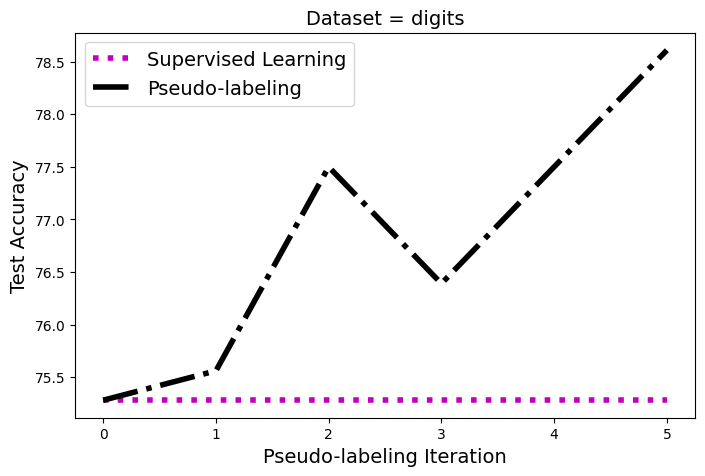

In [12]:
#!python -m pip uninstall matplotlib
#!pip install matplotlib==3.1.3

import matplotlib.pyplot as plt

# plot in the same axis

supervised_learning_result=[ supervised_learning_accuracy ]*len(pseudo_labeling_accuracy)

plt.figure(figsize=(8,5))
plt.plot(np.arange(len(pseudo_labeling_accuracy)),\
         supervised_learning_result,'m:',linewidth=4,label="Supervised Learning")
plt.plot(pseudo_labeling_accuracy,'k-.',linewidth=4,label='Pseudo-labeling')

plt.xlabel("Pseudo-labeling Iteration",fontsize=14)
plt.ylabel("Test Accuracy",fontsize=14)

plt.legend(fontsize=14)

plt.title("Dataset = " + dataset_name,fontsize=14 )

# Run the proposed Confident Sinkhorn Allocation (CSA)

In [13]:
num_XGB_models=10
confidence_choice='ttest'

csa_model = CSA(x_unlabeled,x_test,y_test,
                num_iters=numIters,
                confidence_choice=confidence_choice,
                num_XGB_models=num_XGB_models,
                verbose = True,
            )
csa_model.fit(x_train, y_train)

csa_accuracy=csa_model.test_acc

no of unlabelled data: 1294 	 no of test data: 360
number of used XGB models  M= 10
===== CSA_ttest
==label_frequency without adjustment [22 20 16 13 18 11 17 12  6  8]


  0%|          | 0/5 [00:00<?, ?it/s]

+++Test Acc: 75.28%


 20%|██        | 1/5 [00:03<00:14,  3.73s/it]

num_points accepted=  1014  total num_points= 1294
#unlabel=1294 #points/#classes=1014/10=101.40 reg=0.20
MaxPseudoPoint [67, 61, 49, 40, 55, 34, 52, 37, 19, 25]
#augmented: [array([67, 61, 49, 40, 55, 34, 52, 37, 19, 25])]  len of training data  582
+++Test Acc: 76.67%


 40%|████      | 2/5 [00:11<00:18,  6.06s/it]

num_points accepted=  636  total num_points= 855
#unlabel=855 #points/#classes=636/10=63.60 reg=0.10
MaxPseudoPoint [36, 32, 26, 21, 29, 18, 28, 20, 10, 13]
#augmented: [array([67, 61, 49, 40, 55, 34, 52, 37, 19, 25]), array([36, 32, 26, 21, 29, 18, 28, 20, 10, 13])]  len of training data  815
+++Test Acc: 78.33%


 60%|██████    | 3/5 [00:19<00:14,  7.03s/it]

num_points accepted=  426  total num_points= 622
#unlabel=622 #points/#classes=426/10=42.60 reg=0.05
MaxPseudoPoint [20, 18, 14, 12, 16, 10, 15, 11, 6, 7]
#augmented: [array([67, 61, 49, 40, 55, 34, 52, 37, 19, 25]), array([36, 32, 26, 21, 29, 18, 28, 20, 10, 13]), array([20, 18, 14, 12, 16, 10, 15, 11,  6,  7])]  len of training data  944
+++Test Acc: 79.44%


 80%|████████  | 4/5 [00:26<00:06,  6.99s/it]

num_points accepted=  318  total num_points= 493
#unlabel=493 #points/#classes=318/10=31.80 reg=0.05
MaxPseudoPoint [11, 10, 8, 6, 9, 6, 8, 6, 3, 4]
#augmented: [array([67, 61, 49, 40, 55, 34, 52, 37, 19, 25]), array([36, 32, 26, 21, 29, 18, 28, 20, 10, 13]), array([20, 18, 14, 12, 16, 10, 15, 11,  6,  7]), array([7, 9, 8, 6, 9, 6, 8, 6, 3, 4])]  len of training data  1010
+++Test Acc: 79.44%


100%|██████████| 5/5 [00:35<00:00,  7.12s/it]

num_points accepted=  261  total num_points= 427
#unlabel=427 #points/#classes=261/10=26.10 reg=0.05
MaxPseudoPoint [5, 4, 4, 3, 4, 3, 4, 3, 2, 2]
#augmented: [array([67, 61, 49, 40, 55, 34, 52, 37, 19, 25]), array([36, 32, 26, 21, 29, 18, 28, 20, 10, 13]), array([20, 18, 14, 12, 16, 10, 15, 11,  6,  7]), array([7, 9, 8, 6, 9, 6, 8, 6, 3, 4]), array([3, 4, 4, 3, 4, 3, 4, 3, 2, 2])]  len of training data  1042


+++Test Acc: 80.28%


# Plot the comparison between Supervised, Pseudo-labeling and CSA

In [ ]:
# plot in the same axis

supervised_learning_result=[ supervised_learning_accuracy ]*len(pseudo_labeling_accuracy)

plt.figure(figsize=(8,5))

# Supervised Learning
plt.plot(np.arange(len(pseudo_labeling_accuracy)),\
         supervised_learning_result,'m:',linewidth=4,label="Supervised Learning")

# Pseudo Labeling
plt.plot(pseudo_labeling_accuracy,'k-.',linewidth=4,label='Pseudo-labeling')

# CSA
plt.plot(csa_accuracy,'r-',linewidth=4,label='CSA')

plt.xlabel("Pseudo-labeling Iteration",fontsize=14)
plt.ylabel("Test Accuracy",fontsize=14)

plt.legend(fontsize=12)

plt.title("Dataset = " + dataset_name,fontsize=14 )

# # Run ablation study of CSA without ttest, using all data points, like the SLA paper

In [ ]:
confidence_choice="none"

# SLA model ~ CSA without ttest

sla_model = CSA(x_unlabeled,x_test,y_test,
                num_iters=numIters,
                confidence_choice=confidence_choice,
                num_XGB_models=num_XGB_models,
                verbose = True,
            )
sla_model.fit(x_train, y_train)

sla_accuracy=sla_model.test_acc

In [ ]:
# plot in the same axis

supervised_learning_result=[ supervised_learning_accuracy ]*len(pseudo_labeling_accuracy)

plt.figure(figsize=(8,5))

# Supervised Learning
plt.plot(np.arange(len(pseudo_labeling_accuracy)),\
         supervised_learning_result,'m:',linewidth=4,label="Supervised Learning")

# Pseudo Labeling
plt.plot(pseudo_labeling_accuracy,'k-.',linewidth=4,label='Pseudo-labeling')

# SLA
plt.plot(sla_accuracy,'b:',linewidth=4,label='SLA')

# CSA
plt.plot(csa_accuracy,'r-',linewidth=4,label='CSA')

plt.xlabel("Pseudo-labeling Iteration",fontsize=14)
plt.ylabel("Test Accuracy",fontsize=14)

plt.legend(fontsize=12)

plt.title("Dataset = " + dataset_name,fontsize=14 )